In [1]:
import numpy as np
import torch
from models import MPS
import matplotlib.pyplot as plt

In [2]:
L=4
local_dim =2
bond_dim = 10

In [3]:
psi =MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

In [4]:
fname = "datasets/samples_ghz_plus_z_basis_only_L=4_Nmeasure=100000.npy"
xtr = np.load(fname)[:10000,...]

In [5]:
xtr = torch.tensor((xtr + 1)/2).to(torch.long)

In [6]:
from torch.utils.data import TensorDataset, DataLoader

In [7]:
ds = TensorDataset(xtr)

In [8]:
batch_size = 64
epochs = 10

In [9]:
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [10]:
lr = .001
optim = torch.optim.Adam(lr=lr,params=psi.parameters())

In [11]:
losses = []
p10 = []
p01 = []
p0 = []
p1 = []

In [12]:
x10 = torch.tensor([1,0,1,0], dtype=torch.long)
x01 = 1-x10
x0= torch.zeros(1, L,dtype=torch.long)
x1 = torch.ones(1,L,dtype=torch.long)

In [13]:
for n in range(epochs):
    for x, in dl:
        psi.zero_grad()
        loss = psi.nll_loss(x)
        loss.backward()
        optim.step()
    losses.append(loss)

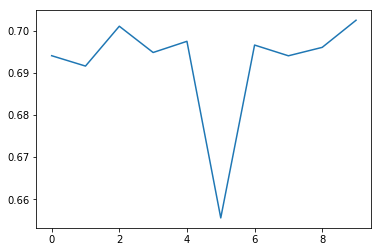

In [15]:
%matplotlib inline
plt.plot(losses)